In [2]:
import random
import numpy as np
import pandas as pd
import math
from scipy.special import comb , perm
import itertools
from tqdm import tqdm
pd.set_option('display.max_rows', 1000)

# 德州扑克数据分析与胜率

## 分析背景

****

*背景*
<ul>经常在b站看德扑的视频，了解到dwan，上海王等高端玩家的心理博弈，非常精彩，不由得想：</ul>
<li>德州扑克是否也能通过数据分析来量化胜率?</li>
<li>是否有各种情况的最优解? </li>
<li>牌面大小、人数、筹码量、位置、人设、入场率、跟注率 等等这些指标是否能用数据结构来表达？</li> 
<li>如果一切都可以计算，那么能否有个“无敌的”AI算法呢？</li>

****

## 第一步：规则，牌面、数据结构

### 规则

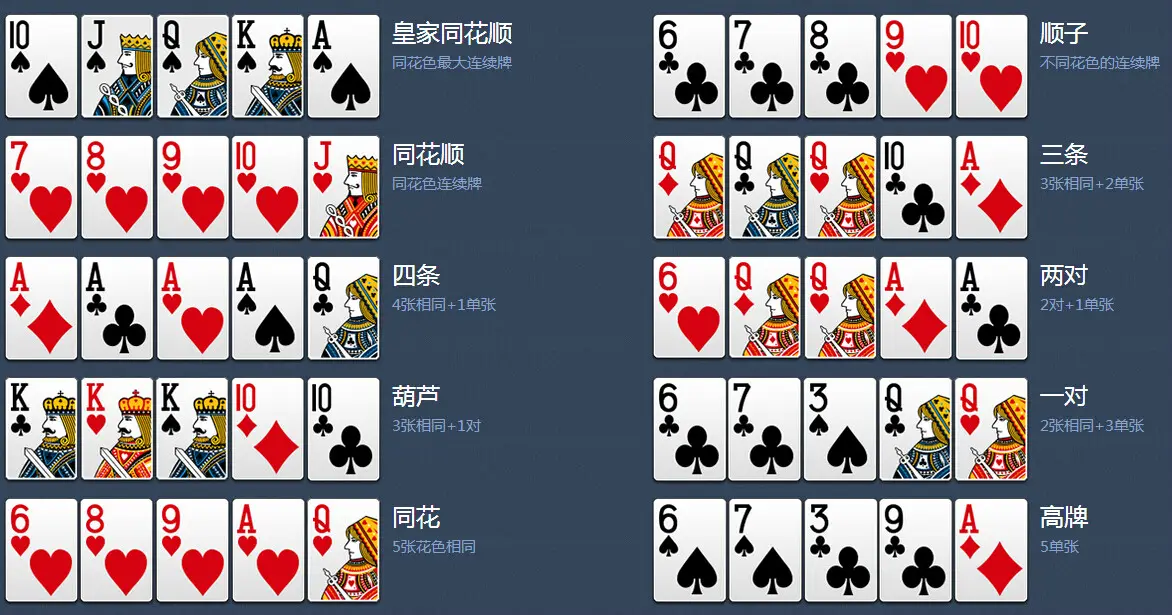

In [3]:
# 牌面大小用数组、0,1是补充索引
ranks = ['0123456789TJQKA']

**花色用首字母大写 黑桃 S - Spade，梅花C - Club，方块D - Diamonds，红桃H - Hearts**

### 数据结构

**非规则数据，采用文本格式处理**

In [4]:
# example
# 黑桃5，方片5，红桃9，梅花9，黑桃Q
cards = '5S 5C 9C 9S QS'

In [5]:
# 取索引大小
['0123456789TJQKA'.index(r) for r,s in cards.split()]

[5, 5, 9, 9, 12]

### 基础函数

In [6]:
def number_ranks(cards):
    '''
    卡牌数字大小的排序
    '''
    ranks = ['0123456789TJQKA'.index(number) for number, color in cards.split()]
    ranks.sort(reverse=True)
    return ranks

In [7]:
# 测试
number_ranks(cards)

[12, 9, 9, 5, 5]

In [8]:
cards = '5S 5D AC AS QS'

In [9]:
def same_color_count(same_num, cards):
    '''判断花色数量和花色，返回的是花色，列表'''
    color_list = [color for number, color in cards.split()]
    res = []
    for i in color_list:
        if color_list.count(i) == same_num:
            res.append(i)
    return list(set(res))
same_color_count(4, cards)

[]

In [10]:
def same_number_count(same_num, cards):
    '''判断数字数量,返回的是牌面'''
    number_list = [number for number, color in cards.split()]
    res = []
    for i in number_list:
        if number_list.count(i) == same_num:
            res.append(i)
    return sorted(list(set(res)),reverse=True)
same_number_count(2, cards)

['A', '5']

## 牌型规则

### 判断顺子

In [11]:
# 牌是不同的5张数值
# 最大 - 最小 = 4 
def analyze_straight(cards):
    card_list = number_ranks(cards)
    if len(set(number_ranks(cards)))==5 and max(card_list) - min(card_list) == 4:
        return True

### 判断同花

In [12]:
def analyze_same_color(cards):
    if len(same_color_count(5, cards)) >0:
        return True

### 判断炸弹

In [13]:
def analyze_boom(cards):
    if len(same_number_count(4, cards)) >0: 
        return True

### 判断葫芦

In [14]:
def analyze_fullhouse(cards):
    if len(same_number_count(3, cards)) >0 and len(same_number_count(2, cards)) >0: 
        return True

### 判断3条

In [15]:
def analyze_three_set(cards):
    if len(same_number_count(3, cards)) >0 : 
        return True

### 判断一对

In [16]:
def analyze_one_pair(cards):
    if len(same_number_count(2, cards)) >0 : 
        return True

### 判断两对

In [17]:
def analyze_two_pair(cards):
    if len(same_number_count(2, cards)) == 2 : 
        return True

## 9种牌型的大小排序函数

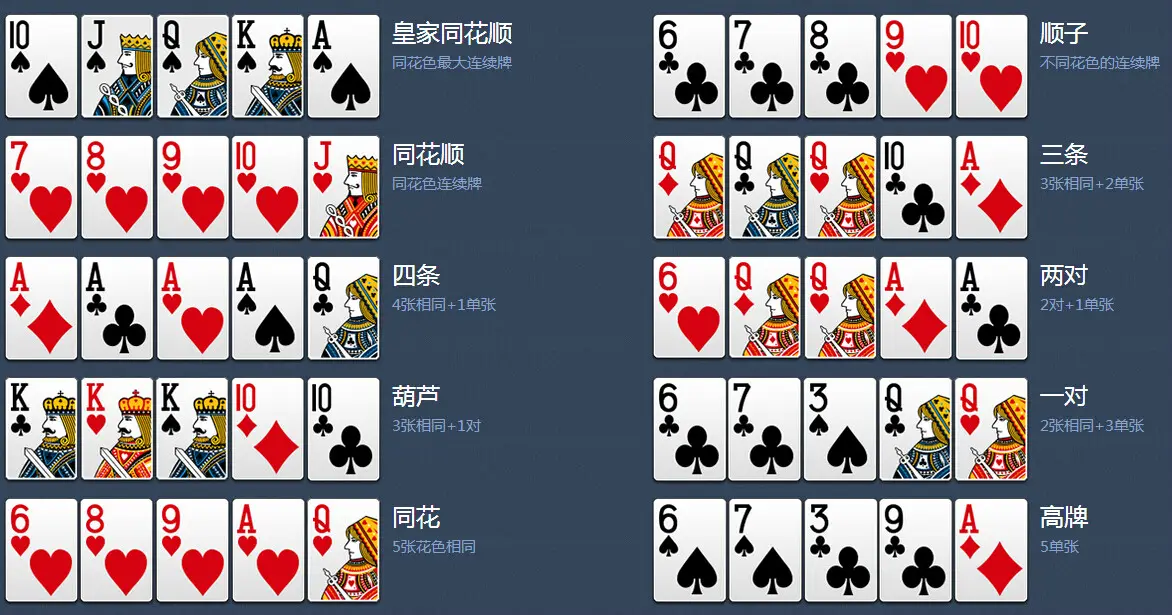

**如何比较人与人之间的手牌大小？**

**要点有两个**
<li> 先比较牌型大小</li>
<li> 如果牌型相同，在同牌型比较“首牌”大小，如54678 < 89TJQ 又或者是 55533 < KKK77, 又或者是 A5544 < Q5599 </li>
<br>
**因此我们需要对于分析一人手牌的函数 输出3个东西：**
<li> 牌型排名</li>
<li> 起始牌</li>
<li> 第二张判断牌</li>
<br>

所以，这个函数应该长下面这个样子

```python 
def analyze_one_hand_rank(cards):

    return hand_card_score, first_card_num, second_card_num
``` 


<hr></hr>

**冲~**

### 单一函数 分析单人的手牌大小

In [18]:
reference = '0123456789TJQKA'
reference_name_to_num={}
for i in reference :
    reference_name_to_num[reference.index(i)] = i
# 新增牌力到牌面的转化字典
reference_name_to_num

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'T',
 11: 'J',
 12: 'Q',
 13: 'K',
 14: 'A'}

In [19]:
def analyze_one_hand_rank(cards):
#     先排序
    cards = ' '.join(sorted(cards.split()))
#     函数分析每个人的手牌大小
    hand_card_type = 0
    first_card = None
    second_card = None
    cards_list = number_ranks(cards)
    reference = '0123456789TJQKA'
    # 皇家同花顺 
    if analyze_same_color(cards) and analyze_straight(cards) and max(cards_list) == 14:
        return {'hand_card_score':10, 'first_card':reference_name_to_num[max(cards_list)],'first_card_score': max(cards_list),'second_card':None,'second_card_score':None,'hand_card_type_name':'皇家同花顺','cards_detail':cards}
    
    # 同花顺
    if analyze_same_color(cards) and analyze_straight(cards):
        return {'hand_card_score':9, 'first_card': reference_name_to_num[max(cards_list)],'first_card_score': max(cards_list),'second_card':None,'second_card_score':None,'hand_card_type_name':'同花顺','cards_detail':cards}
    
    # 四条
    if analyze_boom(cards):
        return {'hand_card_score':8,'first_card': same_number_count(4,cards)[0],'first_card_score': reference.index(same_number_count(4,cards)[0]),'second_card':None,'second_card_score':None,'hand_card_type_name':'炸弹四条','cards_detail':cards}
    
    # 葫芦
    if analyze_fullhouse(cards):
        return {'hand_card_score':7,'first_card': same_number_count(3,cards)[0], 'first_card_score': reference.index(same_number_count(3,cards)[0]),'second_card': same_number_count(2,cards)[0],'second_card_score':reference.index(same_number_count(2,cards)[0]),'hand_card_type_name':'葫芦','cards_detail':cards}
    
    # 同花
    if analyze_same_color(cards):
        return {'hand_card_score':6,'first_card': reference_name_to_num[max(cards_list)],'first_card_score': max(cards_list),'second_card':None,'second_card_score': None,'hand_card_type_name':'同花','cards_detail':cards}
    
    # 顺子
    if analyze_straight(cards):
        return {'hand_card_score':5,'first_card': reference_name_to_num[max(cards_list)],'first_card_score': max(cards_list) ,'second_card':None,'second_card_score': None,'hand_card_type_name':'顺子','cards_detail':cards}
    
    # 三条
    if analyze_three_set(cards):
        return {'hand_card_score':4,'first_card':same_number_count(3,cards)[0] ,'first_card_score': reference.index(same_number_count(3,cards)[0]) ,'second_card':None,'second_card_score': None,'hand_card_type_name':'三条','cards_detail':cards}
    
    # 两对
    if analyze_two_pair(cards):
        return {'hand_card_score':3,'first_card':same_number_count(2,cards)[0] ,'first_card_score': reference.index(same_number_count(2,cards)[0]) ,'second_card':same_number_count(2,cards)[1], 'second_card_score': reference.index(same_number_count(2,cards)[1]),'hand_card_type_name':'两对','cards_detail':cards}
    
    # 一对
    if analyze_one_pair(cards):
        return {'hand_card_score':2,'first_card':same_number_count(2,cards)[0], 'first_card_score': reference.index(same_number_count(2,cards)[0]) ,'second_card':None,'second_card_score': None,'hand_card_type_name':'一对','cards_detail':cards}
    
    # 高牌
    return {'hand_card_score':1,'first_card': reference_name_to_num[max(cards_list)], 'first_card_score': max(cards_list) ,'second_card':None,'second_card_score': None,'hand_card_type_name':'高牌','cards_detail':cards}

In [20]:
cards = '2C 3C 4C 5C 6C'
cards = '5D 6C 7C 8C 9C'
cards = '5D 7C 7H 7C 9C'
cards = '5H 7D 8C 5C 7S'
cards = '2C 3C 4C 5C 6C'
cards = 'AH QD 8C 5C 7S'
cards = '2H 3H 4H 9H 9C'
cards = '2H 3H 4H TH TC'
cards = '2H 3H TH 2C TC'
cards = 'KC KD KH KS JC'
cards = '3H 3C 3D AD 3S'

In [21]:
analyze_one_hand_rank(cards)

{'hand_card_score': 8,
 'first_card': '3',
 'first_card_score': 3,
 'second_card': None,
 'second_card_score': None,
 'hand_card_type_name': '炸弹四条',
 'cards_detail': '3C 3D 3H 3S AD'}

### 模拟场景

**手写好麻烦 ... 写个自动发牌器**

发牌器应该有的功能为：

<li>构建全新卡牌包</li>
<li>拿牌</li>
<li>返回剩余卡牌</li>


#### 卡包构建

In [22]:
def build_new_poker_bag():
    # 洗牌，建立一个卡包
    poker_number_list = '2,3,4,5,6,7,8,9,T,J,Q,K,A'.split(',')
    poker_color_list = 'H,C,D,S'.split(',')    

    full_cards_list=[]
    for color in poker_color_list:
         for number in  poker_number_list:
                one_card = number+color
                full_cards_list.append(one_card)
    print('构建新卡包，洗牌完成，共有{}张牌'.format(len(full_cards_list)))
    return full_cards_list

# 全局变量
global full_cards_list
full_cards_list = build_new_poker_bag()

构建新卡包，洗牌完成，共有52张牌


#### 抽卡

In [23]:
# 拿牌
def draw_cards(cards_num):
# 拿牌
# draw_cards = random.choices(full_cards_list, k = cards_num, replace = False)
# 踩坑，random choice是无放回的

    draw_cards = list(np.random.choice(full_cards_list, cards_num, replace=False))
    for x in draw_cards:
        full_cards_list.remove(x)
        
    print('牌堆还剩{}张'.format(len(full_cards_list)))
    cards = ' '.join(draw_cards)
    return cards
# draw_cards(cards_num = 2)

**可能还需要生成一下玩家...**

#### 生成玩家

In [24]:
def generate_play(num_of_player):
    player_list = []
    for i in range(1,num_of_player+1):
        player_list.append('player {}'.format(i))
    return player_list

# generate_play(5)

#### 给玩家发牌

In [25]:
player_list = generate_play(9)
# 模拟一个游戏
simulated_poker_game = []
# 构建玩家信息
for player in player_list:
    single_player={}
    single_player['player_name'] = player
    simulated_poker_game.append(single_player)
# 给玩家发牌
for x in simulated_poker_game:
    x['current_hands'] = draw_cards(cards_num = 5)

牌堆还剩47张
牌堆还剩42张
牌堆还剩37张
牌堆还剩32张
牌堆还剩27张
牌堆还剩22张
牌堆还剩17张
牌堆还剩12张
牌堆还剩7张


#### 开始pk

In [26]:
# 洗牌
full_cards_list = build_new_poker_bag()
# 计算结果
for single_player in simulated_poker_game:
    single_player.update(analyze_one_hand_rank(single_player['current_hands']))
# 构建结果集
final_df = pd.DataFrame(simulated_poker_game).sort_values(by=['hand_card_score','first_card_score','second_card_score'],ascending=False)
final_df['win_result'] = final_df.reset_index().index + 1
print('获得胜利的是 {}!!!!'.format(final_df[final_df['win_result'] == 1]['player_name'].values[0]))
final_df

构建新卡包，洗牌完成，共有52张牌
获得胜利的是 player 1!!!!


,player_name,current_hands,hand_card_score,first_card,first_card_score,second_card,second_card_score,hand_card_type_name,cards_detail,win_result
0,player 1,6D AS 8C 5C AC,2,A,14,None,None,一对,5C 6D 8C AC AS,1
4,player 5,AH KD 9H KC JD,2,K,13,None,None,一对,9H AH JD KC KD,2
6,player 7,TS TH 6C QD 2H,2,T,10,None,None,一对,2H 6C QD TH TS,3
2,player 3,7S JC 7H 5D 3S,2,7,7,None,None,一对,3S 5D 7H 7S JC,4
3,player 4,9S KS 2D 2S 8H,2,2,2,None,None,一对,2D 2S 8H 9S KS,5
1,player 2,2C 5H AD 7D 6S,1,A,14,None,None,高牌,2C 5H 6S 7D AD,6
7,player 8,4D QH 9C 8D 5S,1,Q,12,None,None,高牌,4D 5S 8D 9C QH,7
8,player 9,QS 4H 6H 7C TC,1,Q,12,None,None,高牌,4H 6H 7C QS TC,8
5,player 6,JH 3H 9D 4S 8S,1,J,11,None,None,高牌,3H 4S 8S 9D JH,9


## 德州扑克的概率问题

**解决了基本的卡牌数据结构，牌型大小之后，我不禁开始思考，为什么三条的牌型 大于 两对，如何量化他的概率，他的底层逻辑到底是怎样的？**

首先1张牌的概率是 1/52

In [64]:
full_cards_list = build_new_poker_bag()

构建新卡包，洗牌完成，共有52张牌


**德州扑克规则的本质：是从2张底牌、5张公共牌中选择 最棒的5张牌组合**

### 先算底牌（手牌）概率

计算翻前发到特定底牌的概率非常简单。每个牌手在牌局开始时将发到两张起手牌。</br>每个牌手只能看到自己的底牌，不能看到别人发到的牌。</br>因此，牌手发到的第一张牌是52张牌中的一张，而第二张牌是牌堆剩下的51张牌中的一张。</br>
因此，德州扑克中总共有52 x 51 / 2 = 1326种可能的底牌组合。

In [28]:
# 两种方式取排列组合
possible_hands = itertools.combinations(full_cards_list,2)
comb(52,2) #无序
# 有序，从3里面取2 perm(4,2)

1326.0

也就是说我们需要看下我们拿到的底表概率是如何的

In [29]:
possible_hands_list = list(possible_hands)

In [30]:
pd.DataFrame([
    {'牌型':'AA对','概率':'{}'.format(comb(4,2)/comb(52,2))},
    {'牌型':'AA,KK对','概率':'{}'.format(comb(4,2)*2/comb(52,2))},
    {'牌型':'口袋对QQ+', '概率':'{}'.format(comb(4,2)*3/comb(52,2))},
    {'牌型':'口袋对JJ+', '概率':'{}'.format(comb(4,2)*4/comb(52,2))},
    {'牌型':'口袋对TT+', '概率':'{}'.format(comb(4,2)*5/comb(52,2))},
    {'牌型':'任意口袋对', '概率':'{}'.format(comb(4,2)*13/comb(52,2))},
    {'牌型':'A、K同花', '概率':'{}'.format(comb(2,2)*4/comb(52,2))},
    {'牌型':'任意大于Q的两张牌', '概率':'{}'.format(comb(12,2)/comb(52,2))},
    {'牌型':'任意大于J的两张牌', '概率':'{}'.format(comb(16,2)/comb(52,2))},
    {'牌型':'任意大于10的两张牌', '概率':'{}'.format(comb(20,2)/comb(52,2))},
    {'牌型':'任意大于9的两张牌', '概率':'{}'.format(comb(24,2)/comb(52,2))},
    {'牌型':'AK、KQ、QJ或JTs', '概率':'{}'.format(comb(4,1)*comb(4,1)*4/comb(52,2))},
    {'牌型':'同花顺子底牌', '概率':'{}'.format(4*12/comb(52,2))},
    {'牌型':'顺子底牌', '概率':'{}'.format(comb(4,1)*comb(4,1)*12/comb(52,2))},
    {'牌型':'任意同花牌', '概率':'{}'.format(comb(13,2)*4/comb(52,2))},
             ])

,牌型,概率
0,AA对,0.004524886877828055
1,"AA,KK对",0.00904977375565611
2,口袋对QQ+,0.013574660633484163
3,口袋对JJ+,0.01809954751131222
4,口袋对TT+,0.02262443438914027
5,任意口袋对,0.058823529411764705
6,A、K同花,0.0030165912518853697
7,任意大于Q的两张牌,0.049773755656108594
8,任意大于J的两张牌,0.09049773755656108
9,任意大于10的两张牌,0.14328808446455504


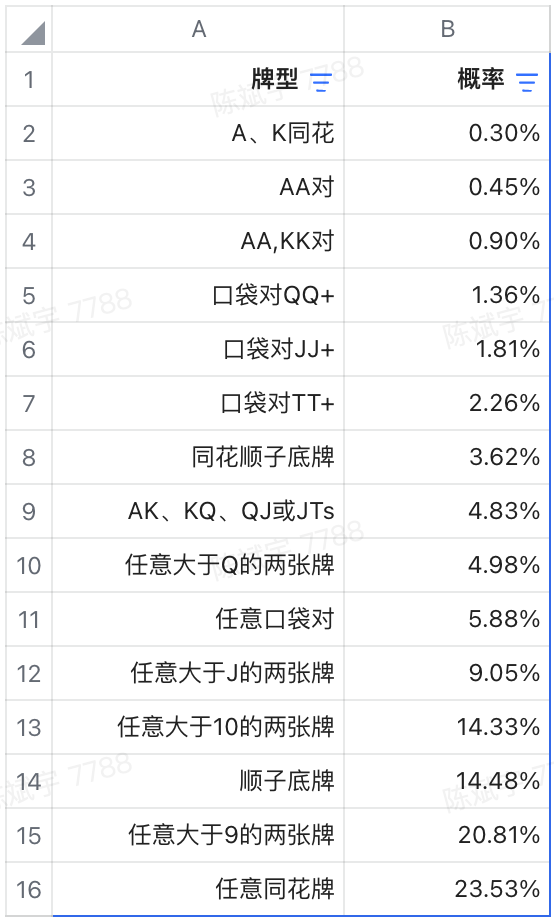

### 整理结果集码表

In [31]:
final = []
for single_combination in tqdm(itertools.combinations(full_cards_list,5)):
    rand_card = ' '.join(list(single_combination))
    try:
        temp = analyze_one_hand_rank(rand_card)
    except:
        print(single_combination)
        break
    final.append(temp)

2598960it [01:02, 41303.40it/s]


In [32]:
full_analyze_deck_df = pd.DataFrame(final)
full_analyze_deck_df = full_analyze_deck_df.sort_values(['hand_card_score','first_card_score','second_card_score'],ascending=False)

In [34]:
full_analyze_deck_df.set_index('cards_detail',inplace=True)

In [35]:
full_analyze_deck_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2598960 entries, AH JH KH QH TH to 2S 4S 5S 6S 7D
Data columns (total 6 columns):
 #   Column               Dtype  
---  ------               -----  
 0   hand_card_score      int64  
 1   first_card           object 
 2   first_card_score     int64  
 3   second_card          object 
 4   second_card_score    float64
 5   hand_card_type_name  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 138.8+ MB


In [53]:
full_analyze_deck_df.groupby('hand_card_type_name')['hand_card_type_name'].count()

hand_card_type_name
一对       1098240
三条         54912
两对        123552
同花          5112
同花顺           32
炸弹四条         624
皇家同花顺          4
葫芦          3744
顺子          9180
高牌       1303560
Name: hand_card_type_name, dtype: int64

In [54]:
full_analyze_deck_df['second_card_score'].fillna(0,inplace=True) #不填充0的话就会都是NaN
full_analyze_deck_df['total_score'] = full_analyze_deck_df['hand_card_score'] * 1000 + full_analyze_deck_df['first_card_score'] * 100 + full_analyze_deck_df['second_card_score'] #total_score纯粹是为了进行排序，因为python的开窗排序函数用不来。。以后知道了再改

In [84]:
full_analyze_deck_df['lose_rank'] = full_analyze_deck_df['total_score'].rank(method='min',ascending=False)-1 # -1
full_analyze_deck_df['win_rank'] = full_analyze_deck_df['total_score'].rank(method='min',ascending=True)-1 #  -1
full_analyze_deck_df['tie_rank'] = 2598960 - full_analyze_deck_df['win_rank'] - full_analyze_deck_df['lose_rank']

In [85]:
full_analyze_deck_df.head(100)

,hand_card_score,first_card,first_card_score,second_card,second_card_score,hand_card_type_name,total_score,lose_rank,win_rank,tie_rank
cards_detail,,,,,,,,,,
AH JH KH QH TH,10,A,14,None,0.0,皇家同花顺,11400.0,0.0,2598956.0,4.0
AC JC KC QC TC,10,A,14,None,0.0,皇家同花顺,11400.0,0.0,2598956.0,4.0
AD JD KD QD TD,10,A,14,None,0.0,皇家同花顺,11400.0,0.0,2598956.0,4.0
AS JS KS QS TS,10,A,14,None,0.0,皇家同花顺,11400.0,0.0,2598956.0,4.0
9H JH KH QH TH,9,K,13,None,0.0,同花顺,10300.0,4.0,2598952.0,4.0
9C JC KC QC TC,9,K,13,None,0.0,同花顺,10300.0,4.0,2598952.0,4.0
9D JD KD QD TD,9,K,13,None,0.0,同花顺,10300.0,4.0,2598952.0,4.0
9S JS KS QS TS,9,K,13,None,0.0,同花顺,10300.0,4.0,2598952.0,4.0
8H 9H JH QH TH,9,Q,12,None,0.0,同花顺,10200.0,8.0,2598948.0,4.0


### 翻牌区概率

#### 消除flop和底牌

In [135]:
flop = ["2C", "KH", "TS"]

In [136]:
cards = 'KC AC'

In [137]:
for x in cards.split() + flop:
    full_cards_list.remove(x)
print(len(full_cards_list))

ValueError: list.remove(x): x not in list

In [66]:
final = []
for x in tqdm(itertools.combinations(full_cards_list,2)):
    for j in itertools.combinations(list(x)+flop,3):
        rand_card = ' '.join(j) + ' ' + cards
#         print(rand_card,'第一层')
        try:
            temp = analyze_one_hand_rank(rand_card)
            final.append(temp)
        except:
            print('wrong',rand_card)
            break
player_flop_analyze_deck_df = pd.DataFrame(final)
player_flop_analyze_deck_df.drop_duplicates(subset=['cards_detail'],inplace=True)

1081it [00:00, 3603.16it/s]


In [67]:
player_flop_analyze_deck_df.sort_values(['hand_card_score','first_card_score','second_card_score'],ascending=False)

,hand_card_score,first_card,first_card_score,second_card,second_card_score,hand_card_type_name,cards_detail
10011,8,K,13,None,NaN,炸弹四条,AC KC KD KH KS
4731,7,A,14,K,13.0,葫芦,AC AD AH KC KH
4851,7,A,14,K,13.0,葫芦,AC AH AS KC KH
10141,7,A,14,K,13.0,葫芦,AC AD AS KC KH
4721,7,K,13,A,14.0,葫芦,AC AH KC KD KH
...,...,...,...,...,...,...,...
10710,1,A,14,None,NaN,高牌,2C 9S AC JS KC
10712,1,A,14,None,NaN,高牌,9S AC JS KC TS
10720,1,A,14,None,NaN,高牌,2C 9S AC KC QS
10722,1,A,14,None,NaN,高牌,9S AC KC QS TS


In [68]:
player_flop_analyze_deck_df.groupby('hand_card_type_name')['cards_detail'].count().reset_index()

,hand_card_type_name,cards_detail
0,一对,1629
1,三条,102
2,两对,240
3,同花,45
4,炸弹四条,1
5,葫芦,9
6,顺子,16
7,高牌,1343


#### 计算胜率

In [69]:
player_flop_list = player_flop_analyze_deck_df['cards_detail'].to_list()

In [70]:
for i in player_flop_list:
    i = ' '.join(sorted(i.split()))

In [89]:
full_analyze_deck_df[full_analyze_deck_df.index == i]

,hand_card_score,first_card,first_card_score,second_card,second_card_score,hand_card_type_name,total_score,lose_rank,win_rank,tie_rank
cards_detail,,,,,,,,,,
2C 2H 3H AC KC,2,2,2,None,0.0,一对,2200.0,2050380.0,250920.0,297660.0


In [ ]:
full_analyze_deck_df[full_analyze_deck_df.cards_detail == '2H 3H 2C KS JC']

## 后续思路

-- 修改analyze_one_hand_rank的内置对应关系
-- 河牌后的胜率是什么，先算1v1的概率，胜负比，就是我抽到的牌组合vs对方可能抽到的牌的组合，每次记0和1
-- 你需要什么牌，每种牌型的概率
-- 后续展示用网页，在自己的博客上，因为网页打开比较快
-- 底牌的胜率，2118760 * 19600 因为会导致维度爆炸，所以做成大的维度表，维度表的需要盘点分数从高到低，这样只需要做索引取数就可以知道每种牌型的 胜平和负
-- 如果要做索引的话，需要保证每个card_detail的id相同，要么做转码加密，要么做字符串排序，这里我们用字符串排序（不太确定行不行）可以用52张牌做成数字然后排序 → 相加 → 排序